In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def make_random_matrix(n=100, minimum=0, maximum=1):
    return np.random.rand(n, n) * (maximum-minimum) + minimum
def floor_array(arr):
    arr[arr<0] = 0

In [3]:
class RegretMatcher:
    def __init__(self, matrix, rm_plus=False):
        self._matrix = matrix
        self.rm_plus = rm_plus
        self.n, self.m = matrix.shape
        self.t = 0
        self._average_policy = np.array([
            np.ones(matrix.shape[0])/matrix.shape[0],
            np.ones(matrix.shape[1])/matrix.shape[1]
        ])
        self._total_regrets = [
            np.zeros(matrix.shape[0]),
            np.zeros(matrix.shape[1])
        ]
    def erase_total_regrets(self):
        self._total_regrets = [
            np.zeros(self._matrix.shape[0]),
            np.zeros(self._matrix.shape[1])
        ]
    def get_avg_policy_exploitability(self):
        p0brv = (self._matrix @ self._average_policy[1]).max()
        p1brv = (self._matrix.T @ self._average_policy[0]).min()
        return (p0brv - p1brv)/2
    def iterate(self):
        # Compute current policy based on cumulative regrets
        positive_regrets = (self._total_regrets[0].copy(), self._total_regrets[1].copy())
        floor_array(positive_regrets[0])
        floor_array(positive_regrets[1])
        policy = np.array([
            positive_regrets[0]/sum(positive_regrets[0]) if sum(positive_regrets[0])>0 else np.ones(self.n)/self.n,
            positive_regrets[1]/sum(positive_regrets[1]) if sum(positive_regrets[1])>0 else np.ones(self.m)/self.m
        ])
        # Compute payoffs and instantaneous regrets and update cumulative regrets
        payoffs = [
            self._matrix   @ policy[1],
            self._matrix.T @ policy[0],
        ]
        value = [
            payoffs[0] @ policy[0],
            payoffs[1] @ policy[1]
        ]
        instantaneous_regrets = [
            payoffs[0] - value[0],
            value[1] - payoffs[1],
        ]
        self._total_regrets[0] += instantaneous_regrets[0]
        self._total_regrets[1] += instantaneous_regrets[1]
        ## RM+ (floor regrets to 0)
        if self.rm_plus:
            self._total_regrets[0][self._total_regrets[0]<0] = 0
            self._total_regrets[1][self._total_regrets[1]<0] = 0
        # Update average policy and increment iteration counter
        self._average_policy = self._average_policy * self.t/(self.t+1) + policy * 1/(self.t+1)
        self.t += 1
    def get_upsilon(self):
        delta = np.amax(self._matrix) - np.amin(self._matrix)
        a1 = self.n
        a2 = self.m
        payoffs = [
            self._matrix   @ self._average_policy[1],
            self._matrix.T @ self._average_policy[0],
        ]
        l = np.amin(payoffs[1]) + 0.0001
        r = np.amax(payoffs[0]) - 0.0001
        def f(upsilon):
            p1 = payoffs[0] - upsilon
            p2 = upsilon - payoffs[1]
            p1[p1<0] = 0
            p2[p2<0] = 0
            if sum(p1) == 0:
                return delta*100
            if sum(p2) == 0:
                return -delta * 100
            p1 = delta*delta*a1 / np.square(p1).sum()
            p2 = delta*delta*a2 / np.square(p2).sum()
#             p1 = delta*delta*a1 * np.square(p2).sum()
#             p2 = delta*delta*a2 * np.square(p1).sum()
            return abs(p2 - p1)
        for i in range(30):
            left_third = l + (r - l) / 3
            right_third = r - (r - l) / 3
            if f(left_third) < f(right_third):
                r = right_third
            else:
                l = left_third
#         assert self.t==0 or abs(f(l) - f(r)) < 0.1, f'{self.t}: {l} {r}, {f(l)}, {f(r)}'
        return l
    def warm_start_regrets(self):
        payoffs = [
            self._matrix   @ self._average_policy[1],
            self._matrix.T @ self._average_policy[0],
        ]
        upsilon = self.get_upsilon()
        self._total_regrets[0] = self.t * payoffs[0] - self.t * upsilon
        self._total_regrets[1] = self.t * upsilon - self.t * payoffs[1]
        ## RM+ (floor regrets to 0)
        if self.rm_plus:
            self._total_regrets[0][self._total_regrets[0]<0] = 0
            self._total_regrets[1][self._total_regrets[1]<0] = 0

# Replicate Figure 1 from "Strategy-Based Warm Starting for Regret Minimization in Games", Noam Brown & Tuomas Sandholm 2015

### RM

In [5]:
rm_exploitabilitiesz = []
for t in tqdm(range(8)):
    game = make_random_matrix(100, -1, 1)
    rm = RegretMatcher(game, rm_plus=False)
    exploitabilities = []
    for i in range(50000):
        rm.iterate()
        exploitabilities.append(rm.get_avg_policy_exploitability())
    rm_exploitabilitiesz.append(exploitabilities)

100%|██████████| 8/8 [00:47<00:00,  5.94s/it]


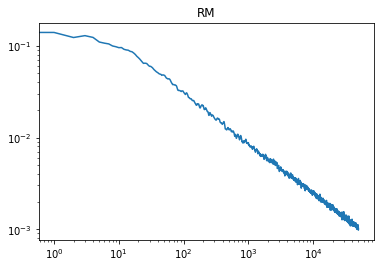

In [6]:
plt.plot([sum(x)/len(x) for x in zip(*rm_exploitabilitiesz)])
plt.yscale('log')
plt.xscale('log')
plt.title('RM')
plt.show()

### RM with Warm Starting

In [7]:
rm_warm_exploitabilitiesz = []
for t in tqdm(range(4)):
    game = make_random_matrix(100, -1, 1)
    rm = RegretMatcher(game, rm_plus=False)
    exploitabilities = []
    for i in range(10000):
        rm.erase_total_regrets()
        rm.warm_start_regrets()
        rm.iterate()
        exploitabilities.append(rm.get_avg_policy_exploitability())
    rm_warm_exploitabilitiesz.append(exploitabilities)

100%|██████████| 4/4 [02:24<00:00, 36.19s/it]


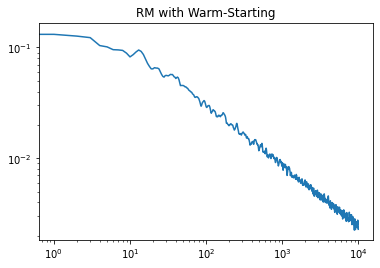

In [8]:
plt.plot([sum(x)/len(x) for x in zip(*rm_warm_exploitabilitiesz)])
plt.yscale('log')
plt.xscale('log')
plt.title('RM with Warm-Starting')
plt.show()

### Comparison

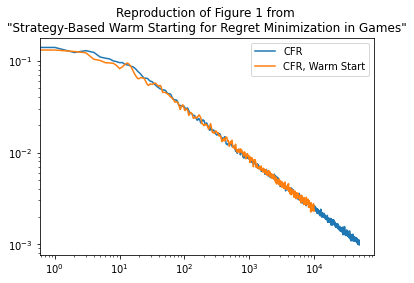

In [9]:
plt.plot([sum(x)/len(x) for x in zip(*rm_exploitabilitiesz)], label='CFR')
plt.plot([sum(x)/len(x) for x in zip(*rm_warm_exploitabilitiesz)], label='CFR, Warm Start')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Reproduction of Figure 1 from \n"Strategy-Based Warm Starting for Regret Minimization in Games"')
plt.show()

# What about RM+?

In [12]:
rm_plus_exploitabilitiesz = []
for t in range(8):
    game = make_random_matrix(100, -1, 1)
    rm = RegretMatcher(game, rm_plus=True)
    exploitabilities = []
    for i in tqdm(range(100000)):
        rm.iterate()
        exploitabilities.append(rm.get_avg_policy_exploitability())
    rm_plus_exploitabilitiesz.append(exploitabilities)

100%|██████████| 100000/100000 [00:23<00:00, 4304.64it/s]


In [13]:
rm_plus_warm_exploitabilitiesz = []
for t in range(4):
    game = make_random_matrix(100, -1, 1)
    rm = RegretMatcher(game)
    exploitabilities = []
    for i in tqdm(range(10000)):
        rm.erase_total_regrets()
        rm.warm_start_regrets()
        rm.iterate()
        exploitabilities.append(rm.get_avg_policy_exploitability())
    rm_plus_warm_exploitabilitiesz.append(exploitabilities)

100%|██████████| 10000/10000 [00:47<00:00, 211.12it/s]


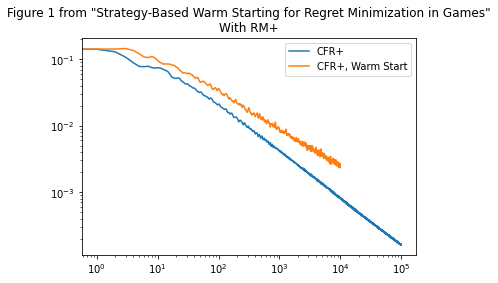

In [14]:
plt.plot([sum(x)/len(x) for x in zip(*rm_plus_exploitabilitiesz)], label='CFR+')
plt.plot([sum(x)/len(x) for x in zip(*rm_plus_warm_exploitabilitiesz)], label='CFR+, Warm Start')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Figure 1 from "Strategy-Based Warm Starting for Regret Minimization in Games"\nWith RM+')
plt.show()